In [1]:
import os
import pandas as pd
import json
from typing import List

from experiments.interpretation.interpretation_util import (
    ExperimentFiles,
    ExperimentFolders,
)


# Base directory setup
notebook_dir = os.path.abspath("")
base_experiment_dir = os.path.join(
    notebook_dir, "..", "results", "experiments", ExperimentFolders.GPT_41
)


# Function to load all experiment files into DataFrames
def load_experiment_data(files: List[ExperimentFiles], base_dir: str) -> pd.DataFrame:
    dfs = []
    for file in files:
        path = os.path.join(base_dir, file)
        try:
            with open(path, "r", encoding="utf-8") as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            df["experiment_name"] = file  # Add column to identify the experiment
            dfs.append(df)
        except Exception as e:
            print(f"Failed to load {file}: {e}")
    return pd.concat(dfs, ignore_index=True)


# Load all experiments
all_files = list(ExperimentFiles)
df_all_experiments = load_experiment_data(all_files, base_experiment_dir)

# Now you can compare/filter by experiment_name
print(df_all_experiments["experiment_name"].value_counts())

experiment_name
triage_local.json                              91
all_tools_local.json                           91
all_tools_local_no_ranking.json                91
triage_mcp.json                                91
triage_mcp_seq_websearch.json                  91
all_tools_mcp_websearch.json                   91
all_tools_mcp_seq.json                         91
all_tools_mcp_seq_websearch.json               91
all_tools_mcp_seq_websearch_no_ranking.json    91
o3_all_tools_local.json                        91
Name: count, dtype: int64


/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_87325/1673228442.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


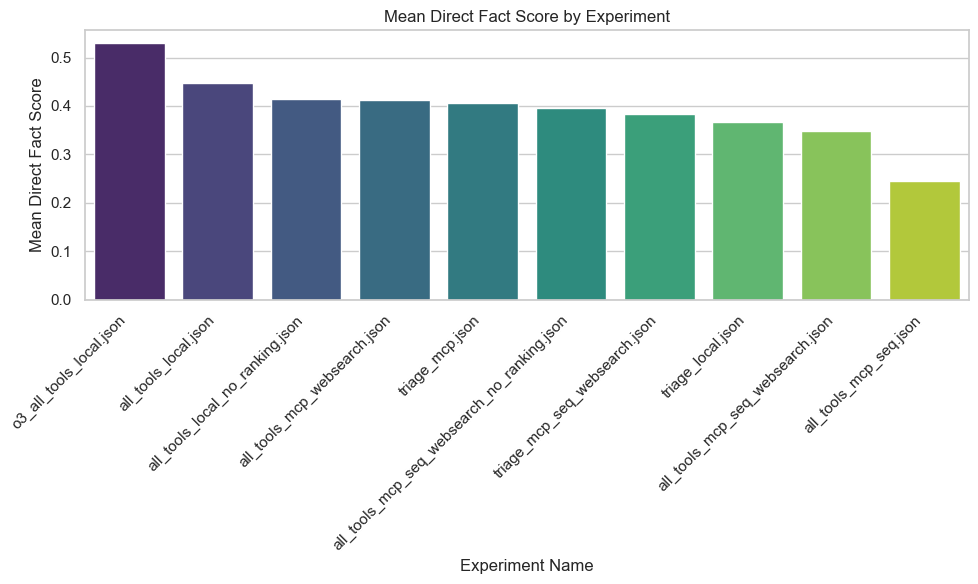

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the visual style
sns.set(style="whitegrid")

# Group and compute mean direct fact score
mean_scores = (
    df_all_experiments.groupby("experiment_name")["fact_score.direct_fact_score"]
    .mean()
    .reset_index()
    .sort_values("fact_score.direct_fact_score", ascending=False)
)

# Plot with vertical bars
plt.figure(figsize=(10, 6))
sns.barplot(
    x="experiment_name",
    y="fact_score.direct_fact_score",
    data=mean_scores,
    palette="viridis",
)

plt.title("Mean Direct Fact Score by Experiment")
plt.ylabel("Mean Direct Fact Score")
plt.xlabel("Experiment Name")
plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
plt.tight_layout()
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_87325/549665664.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


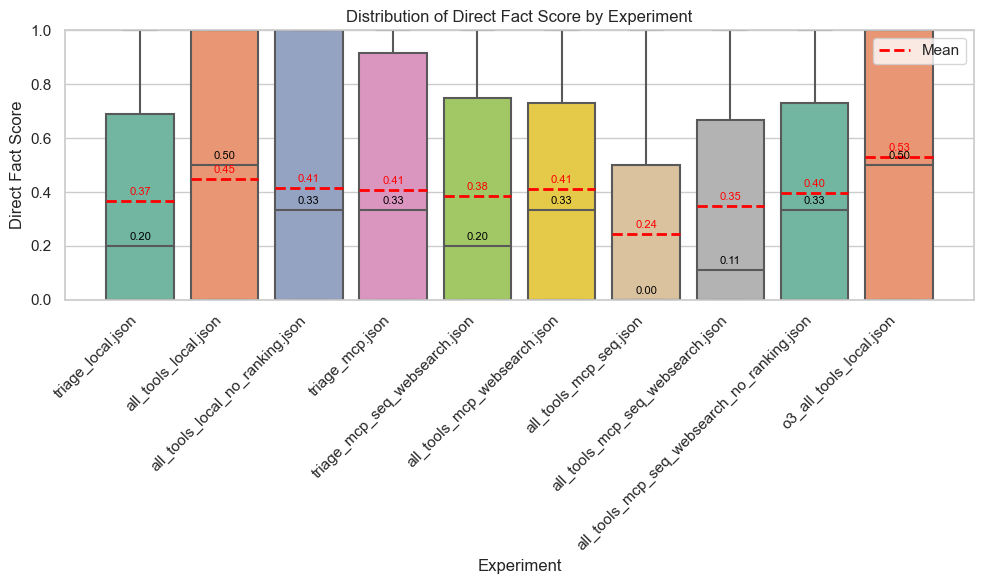

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))

# Draw boxplot and save the axis object
ax = sns.boxplot(
    data=df_all_experiments,
    x="experiment_name",
    y="fact_score.direct_fact_score",
    palette="Set2",
    showfliers=False,
    linewidth=1.5,
)

# Get the x-tick positions (center of each box)
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Compute statistics
means = df_all_experiments.groupby("experiment_name")[
    "fact_score.direct_fact_score"
].mean()
medians = df_all_experiments.groupby("experiment_name")[
    "fact_score.direct_fact_score"
].median()

# Map experiment names to positions
pos_map = {label: pos for label, pos in zip(xticklabels, xticks)}

# Overlay mean line and median label
for experiment, pos in pos_map.items():
    mean_val = means.get(experiment)
    median_val = medians.get(experiment)

    if mean_val is not None:
        # Mean (red dashed line, thicker)
        plt.hlines(
            mean_val,
            pos - 0.40,
            pos + 0.40,
            colors="red",
            linestyles="--",
            linewidth=2,
            label="Mean" if pos == xticks[0] else "",
        )
        plt.text(
            pos,
            mean_val + 0.015,
            f"{mean_val:.2f}",
            color="red",
            va="bottom",
            fontsize=8,
            ha="center",
        )

    if median_val is not None:
        # Median label only, raised slightly
        plt.text(
            pos,
            median_val + 0.015,
            f"{median_val:.2f}",
            color="black",
            va="bottom",
            fontsize=8,
            ha="center",
        )

# Final formatting
plt.title("Distribution of Direct Fact Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Direct Fact Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

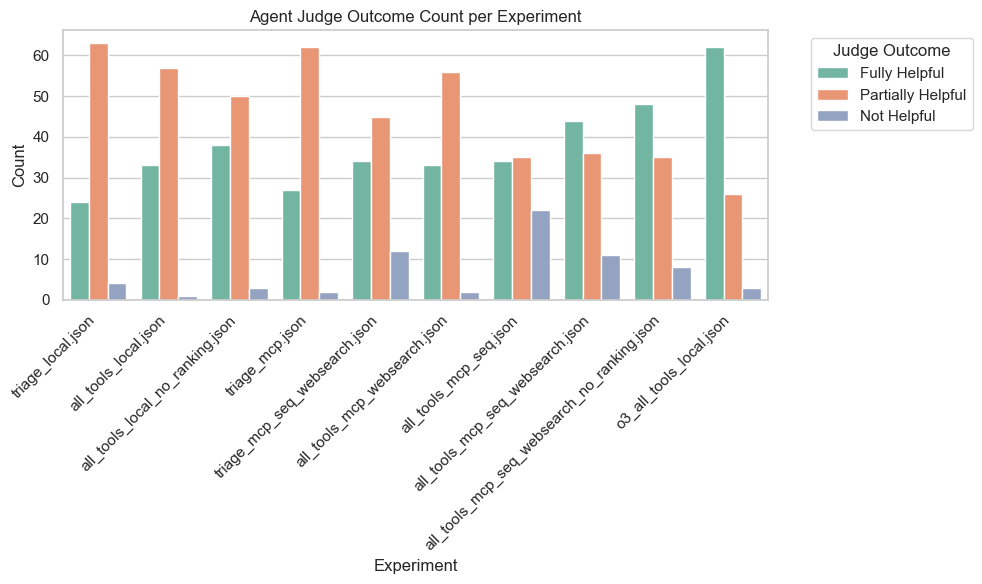

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df_all_experiments,
    x="experiment_name",
    hue="agent_judge_outcome",
    palette="Set2",
)

plt.title("Agent Judge Outcome Count per Experiment")
plt.xlabel("Experiment")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Move the legend outside the plot
plt.legend(title="Judge Outcome", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

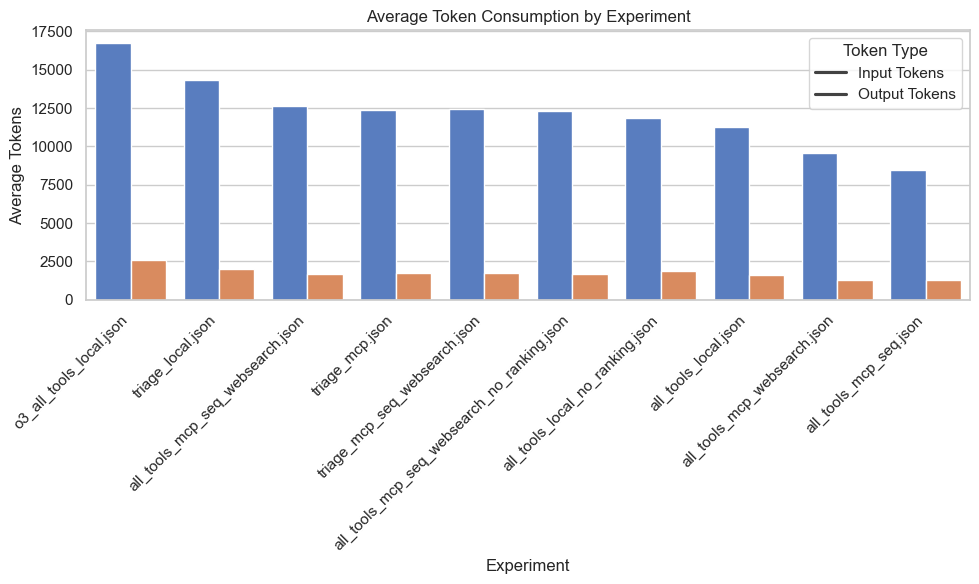

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean token usage by experiment
token_cols = [
    "tokens_consumed.input_tokens",
    "tokens_consumed.output_tokens",
    "tokens_consumed.total_tokens",
]

mean_token_usage = (
    df_all_experiments.groupby("experiment_name")[token_cols]
    .mean()
    .reset_index()
    .sort_values("tokens_consumed.total_tokens", ascending=False)
)

# Melt for stacked bar plotting
melted = mean_token_usage.melt(
    id_vars="experiment_name",
    value_vars=["tokens_consumed.input_tokens", "tokens_consumed.output_tokens"],
    var_name="token_type",
    value_name="avg_tokens",
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=melted, x="experiment_name", y="avg_tokens", hue="token_type", palette="muted"
)

plt.title("Average Token Consumption by Experiment")
plt.ylabel("Average Tokens")
plt.xlabel("Experiment")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Token Type", labels=["Input Tokens", "Output Tokens"])
plt.tight_layout()
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_87325/3060070266.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


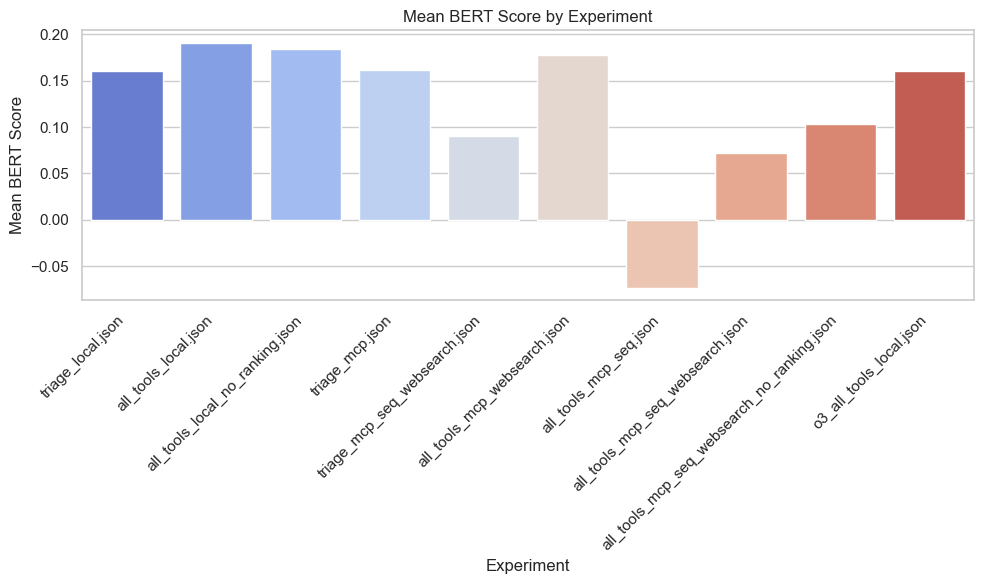

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the order from df_all_experiments
experiment_order = df_all_experiments["experiment_name"].unique()

# Compute mean BERT score per experiment
mean_bert = (
    df_all_experiments.groupby("experiment_name")["bert_score"].mean().reset_index()
)

# Plot using the fixed experiment order
plt.figure(figsize=(10, 6))
sns.barplot(
    data=mean_bert,
    x="experiment_name",
    y="bert_score",
    order=experiment_order,  # preserve consistent order
    palette="coolwarm",
)

plt.title("Mean BERT Score by Experiment")
plt.xlabel("Experiment")
plt.ylabel("Mean BERT Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/nr/mg0w99s91kg0rvjr9xkypfwh0000gn/T/ipykernel_87325/2664345965.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_tools, x="experiment_name", y="tool_calls_count", palette="crest")


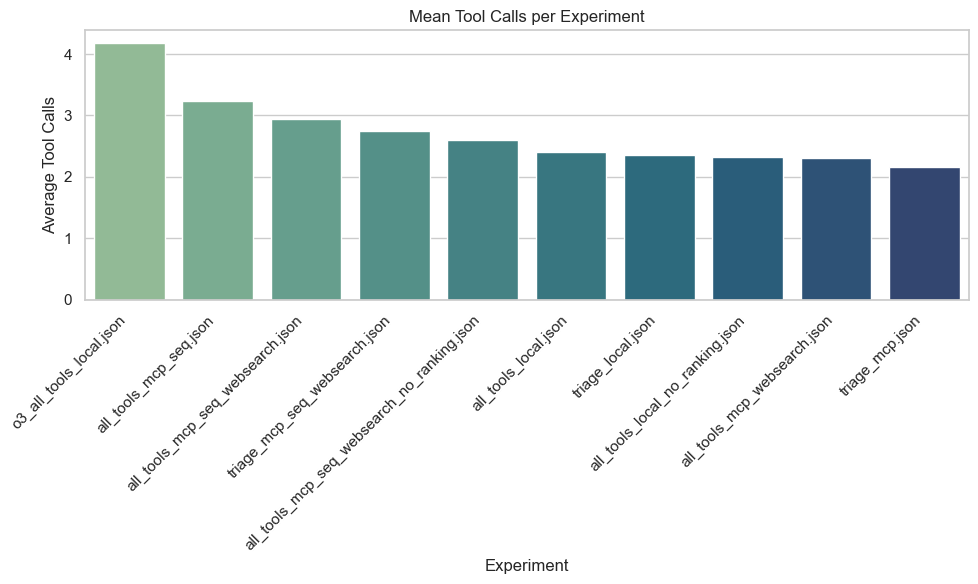

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute mean tool calls
mean_tools = (
    df_all_experiments.groupby("experiment_name")["tool_calls_count"]
    .mean()
    .reset_index()
    .sort_values("tool_calls_count", ascending=False)
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_tools, x="experiment_name", y="tool_calls_count", palette="crest")

plt.title("Mean Tool Calls per Experiment")
plt.xlabel("Experiment")
plt.ylabel("Average Tool Calls")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()